In this Jupyter Notebook, we will perform A/B Testing on user data categorized into Control and Variant groups.

Before delving into that, we'll conduct an Exploratory Data Analysis (EDA) and perform Feature Engineering to prepare the data appropriately.

**Sections**:



- [LIBRARIES](#LIBRARIES)
- [EDA AND DATA CLEANING](#EDA-AND-DATA-CLEANING)
    - [Removing users](#REMOVING-USERS)
    - [Removing outliers](#REMOVING-OUTLIERS)
- [FEATURE ENGINEERING](#FEATURE-ENGINEERING)
- [A/B TESTING](#A/B-TESTING)
    - [A/B Testing on Revenue (difference in means)](#A/B-TESTING-REVENUE)
        - [Permutation test](#PERMUTATION-REVENUE)
        - [T-test](#T-TEST)
        - [Mann-Whitney U rank test](#MANN-WHITNEY-TEST)
    - [A/B Testing on Sales (Propotions)](#A/B-TESTING-SALES)
        - [Permutation test](#PERMUTATION-SALES)
        - [Z-test](#Z-TEST)
        - [Test of independence](#TEST-INDEPENDENCE)
            - [Chi-Square](#CHI-SQUARE)
            - [Fisher's Exact Test](#FISHER-EXACT-TEST)
    - [Conclusions](#CONCLUSIONS)

<a name="LIBRARIES"></a>
# LIBRARIES

In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

<a name="EDA-AND-DATA-CLEANING"></a>
# EDA AND DATA CLEANING

In this section we are going to analyze the data and discover if there are duplicate values and outliers.

In [382]:
df = pd.read_csv('AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [384]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
USER_ID,10000.0,4981.080200,2890.590115,2.0,2468.75,4962.0,7511.5,10000.00
REVENUE,10000.0,0.099447,2.318529,0.0,0.00,0.0,0.0,196.01


In [385]:
df['VARIANT_NAME'].value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

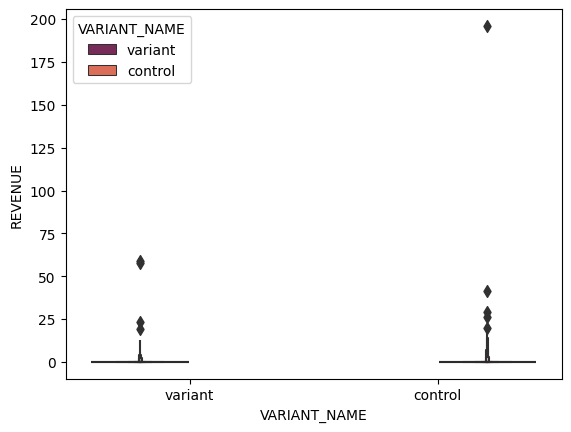

In [386]:
sns.boxenplot(
  df[['VARIANT_NAME', 'REVENUE']], 
  x = "VARIANT_NAME",
  y = 'REVENUE',
  hue="VARIANT_NAME", 
  palette='rocket'
)

In [387]:
df.groupby("USER_ID")["VARIANT_NAME"].nunique().sort_values(ascending=False)

USER_ID
4967    2
4615    2
4586    2
4593    2
4595    2
       ..
1278    1
4678    1
4677    1
4670    1
2       1
Name: VARIANT_NAME, Length: 6324, dtype: int64

- We have users that belong to both the Variant and Control groups.
- We have outliers.

<a name="REMOVING-USERS"></a>
## Removing users

We remove the users that are both Variant and Control.

In [388]:
rows_to_keep = (df.groupby("USER_ID")["VARIANT_NAME"].nunique() == 1)
rows_to_keep = rows_to_keep[rows_to_keep]
df = df[df['USER_ID'].isin(rows_to_keep.index)]

In [389]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
USER_ID,6070.0,4983.664086,2897.990118,2.0,2472.25,4950.0,7501.0,9998.00
REVENUE,6070.0,0.107064,2.673501,0.0,0.00,0.0,0.0,196.01


In [390]:
df.groupby("USER_ID")["VARIANT_NAME"].nunique().sort_values(ascending=False)

USER_ID
2       1
6674    1
6672    1
6671    1
6668    1
       ..
3331    1
3330    1
3327    1
3326    1
9998    1
Name: VARIANT_NAME, Length: 4783, dtype: int64

In [391]:
df['VARIANT_NAME'].value_counts()

VARIANT_NAME
variant    3044
control    3026
Name: count, dtype: int64

Now that we removed some users, let's see if we continue having outliers.

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

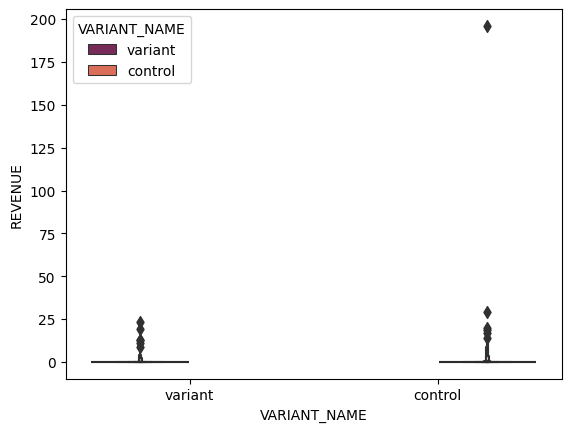

In [392]:
sns.boxenplot(
  df[['VARIANT_NAME', 'REVENUE']], 
  x = "VARIANT_NAME",
  y = 'REVENUE',
  hue="VARIANT_NAME", 
  palette='rocket'
)

We still have outliers, so we proceed to drop them.

<a name="REMOVING-OUTLIERS"></a>
## Removing outliers

Let's determine the most appropriate threshold to identify outliers.

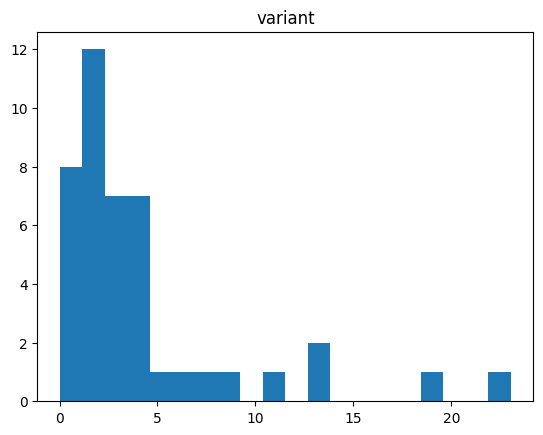

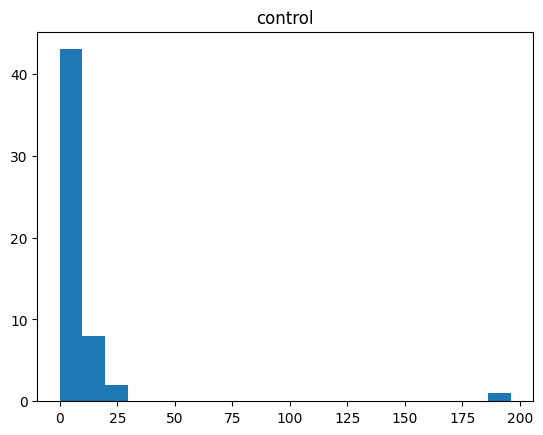

In [393]:
plt.hist(df[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] != 0)]['REVENUE'], bins =20)
plt.title('variant')
plt.show()

plt.hist(df[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] != 0)]['REVENUE'], bins =20)
plt.title('control')
plt.show()

Anything starting at or above 25 on Revenue will be consider an outlier.

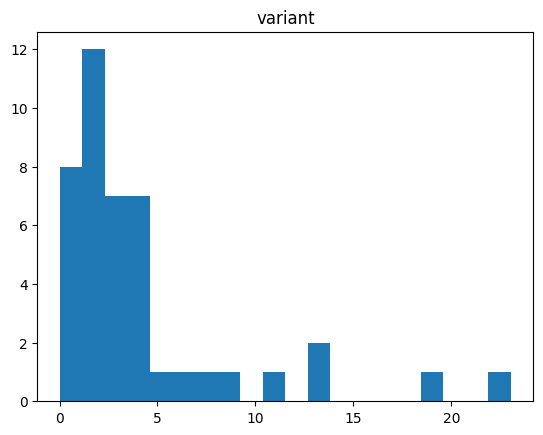

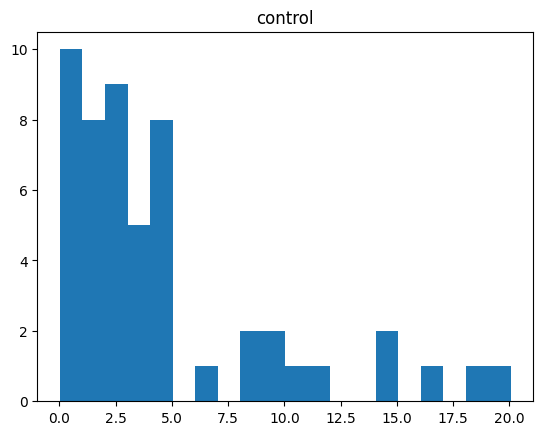

In [394]:
index_to_drop =  df[(df['REVENUE'] >= 25)].index
df.drop(index=index_to_drop, inplace= True)

plt.hist(df[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] != 0)]['REVENUE'], bins =20)
plt.title('variant')
plt.show()

plt.hist(df[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] != 0)]['REVENUE'], bins =20)
plt.title('control')
plt.show()

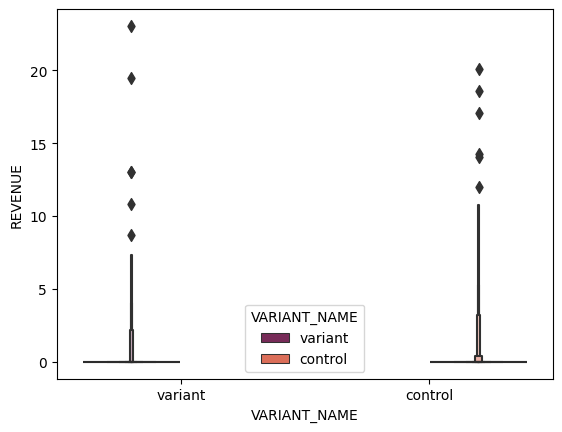

In [395]:
sns.boxenplot(
  df[['VARIANT_NAME', 'REVENUE']], 
  x = "VARIANT_NAME",
  y = 'REVENUE',
  hue="VARIANT_NAME", 
  palette='rocket'
)
plt.show()

<a name="FEATURE-ENGINEERING"></a>
# FEATURE ENGINEERING

We create a new DataFrame by grouping the Revenue data by USER_ID and VARIANT_NAME. Next, we add a new column called SALE, where individuals who have generated non-zero revenue will be assigned a value of 1, while those with zero revenue will be assigned a value of 0.

In [396]:
df_grouped_users = pd.DataFrame(df.groupby(['USER_ID', 'VARIANT_NAME'])['REVENUE'].sum()).reset_index()
df_grouped_users['SALE'] = np.where(df_grouped_users['REVENUE'] == 0, 0, 1)
df_grouped_users

,USER_ID,VARIANT_NAME,REVENUE,SALE
0,2,control,0.0,0
1,4,variant,0.0,0
2,5,variant,0.0,0
3,6,variant,0.0,0
4,9,variant,0.0,0
...,...,...,...,...
4777,9990,variant,0.0,0
4778,9992,control,0.0,0
4779,9993,control,0.0,0
4780,9995,variant,0.0,0


<a name="A/B-TESTING"></a>
# A/B TESTING

General assumptions:
- Randomness: The samples are random subsets of larger population
- Independence of observations: Each observation is independent
- Large sample size: The sample is big enough to mitigate uncertainty, so that the Central Limit Theorem applies

Test assumptions:

- T-test for difference in means:
    - Large sample size: 
    
        - At least 30 observations in each sample. 
        
            n1 >= 30, n2 >= 30

- Mann-Whitney U rank test:
    - The data must be independent.

    - The data must be ordinal or capable of being ordered from least to greatest.

    - It is not necessary to assume that the samples are normally distributed or that they come from normal populations. However, for the test to compare medians, both samples must have the same type of distribution (variance, skewness, etc.).

Equality of variance between groups (homoscedasticity).
- Permutation test for difference in means
- Levene test for equal variances between samples
- Z-test for proportions:
    - Large sample size: 

        - Number of successes in each sample is equal or greater than 10

            n1 * p_hat1 >= 10
            n2 * p_hat2 >= 10
            
        - Number of failures in each sample is equal or greater than 10
        
            n1 * (1-p_hat1) >= 10
            n2 * (1-p_hat2) >= 10

- Permutation test for proportions
- Chi-Square test of Independence:
    - Large sample size:

        - The number of successes in each group is equal or greater than 5

            ni * p_hat_i >= 5 for all values of i

        - The number of failures in each group is equal or greater than 5

            ni * (1-p_hat_i) >= 5 for all values of i

- Fisher's Exact test
    - Fisher's exact test is particularly suitable when dealing with small sample sizes. It is especially useful when the sample sizes are less than 20 or when the cells in the contingency table have very low expected values under the null hypothesis.

In this section, we'll apply different test for proportions and difference in means. The objective is to apply difference tests even if the data does not strictly meet the underlying assumptions to use them and compare the results.

First, let's examine the data with a visualization.

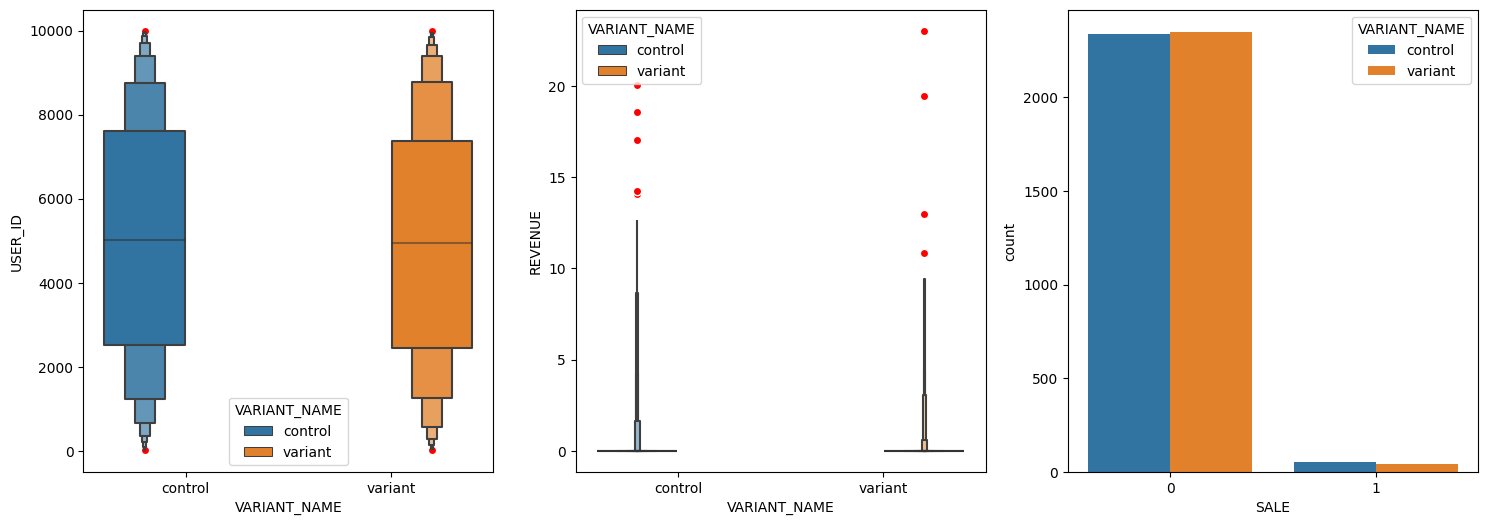

In [397]:

df_grouped_users_num = df_grouped_users.select_dtypes(include='number')
n_cols =  3
red_circle_boxen = dict(color='red', marker='o', edgecolors='white')
# n_rows = int(np.ceil(((df_grouped_users_num.shape[1]-1) / n_cols)))
n_rows = int(np.ceil(((df_grouped_users_num.shape[1]) / n_cols)))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(18, (n_rows*6)))
for i, column in enumerate(df_grouped_users_num.columns):
  # print(i)
  # print(n_cols)
  # print(column)
  # print(axes)
  # print(i//n_cols,i%n_cols)
  if(len(df_grouped_users_num[column].unique()) <= 24): # "categorical" data
    sns.countplot(
      df_grouped_users[[column, 'VARIANT_NAME']],
      x = column,
      hue="VARIANT_NAME", 
      ax=axes[i%n_cols],
      # ax=axes[i//n_cols,i%n_cols],
    )
  else: # if it's not categorical data...

    sns.boxenplot(
      df_grouped_users[[column, 'VARIANT_NAME']],
      x = "VARIANT_NAME",
      hue="VARIANT_NAME", 
      y = column,
      ax=axes[i%n_cols],
      # ax=axes[i//n_cols,i%n_cols],
      flier_kws=red_circle_boxen
    )

The graphs allow us to suspect that there is no difference between Variant and Control among the different variables. Now we start doing the tests.

In [398]:
# DataFrame to display the results at the end
pd.set_option('display.max_colwidth', None)
df_results = pd.DataFrame(columns=['test_for', 'test_type', 'H0', 'H1', 'pvalue', 'results', 'results_details'])

<a name="A/B-TESTING-REVENUE"></a>
## A/B Testing on Revenue (difference in means)

In [399]:
mean_control = df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'control']['REVENUE'].mean()
mean_variant = df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'variant']['REVENUE'].mean()
print(f'mean_control: {mean_control:.4f}')
print(f'mean_variant: {mean_variant:.4f}')
print(f'mean_control - mean_variant: {mean_control - mean_variant:.4f}')

mean_control: 0.1026
mean_variant: 0.0749
mean_control - mean_variant: 0.0277


Based on the calculations for the mean of each group, we make the hypothesis that the variant group generates less revenue than the control group on average.

Null Hypothesis (H0) = No difference on revenue mean between the Control and Variant groups . (mean_control - mean_variant = 0)

Alternative Hypothesis (H1) = Variant group generates less revenue on average / Difference between control and variant revenue means is positive. (mean_control - mean_variant > 0)

<a name="PERMUTATION-REVENUE"></a>
### Permutation test

Permutation test is closer to a one-size-fits-all approach to inference because it doesn't need assumptions about the data. The counterpart is that if the data is big enough, it could be computational expensive.

p-value: 0.1559


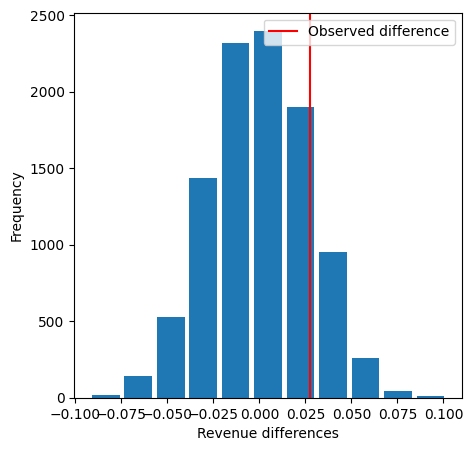

In [400]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

permutation_results = stats.permutation_test(
    (df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'control']['REVENUE'], 
     df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'variant']['REVENUE']),
     statistic,
     vectorized=True,
     alternative='greater'
    )
print(f'p-value: {permutation_results.pvalue:.4f}')

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(permutation_results.null_distribution, bins=11, rwidth=0.85)
ax.axvline(x = mean_control - mean_variant, color='red', label='Observed difference')
ax.set_xlabel('Revenue differences')
ax.set_ylabel('Frequency')

ax.legend();
plt.show()

In [401]:
if permutation_results.pvalue >= 0.05:
    results_hypothesis = "Fail to reject the Null Hypothesis"
    results_hypothesis_details = "Seems like there is no difference between Control and Variant groups on Revenue means"
else:
    results_hypothesis = "Reject the Null Hypothesis"
    results_hypothesis_details = "Seems like Variant group generates less Revenue on average"

df_results_mean_diff_permutation = pd.DataFrame({
    'test_for': "Difference in Revenue means",
    'test_type': "Permutation Test",
    'H0': "No difference on Revenue means",
    'H1': "Mean Revenue on Variant group is lower",
    'pvalue': [permutation_results.pvalue],
    'results': results_hypothesis,
    'results_details': results_hypothesis_details
})

df_results = pd.concat([df_results, df_results_mean_diff_permutation])

df_results_mean_diff_permutation

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Difference in Revenue means,Permutation Test,No difference on Revenue means,Mean Revenue on Variant group is lower,0.1559,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on Revenue means


<a name="T-TEST"></a>
### T-Test

One of the assumptions of the t-test is that the data is normally distributed, which in our case it is clearly not true, but we may justify the use of the t-test because we have sufficient data to apply The Central Limit Theorem. We will attempt to use it just to see the results and then we compare to other test that don't make assumptions on normality.

#### Levene test (for equal variances)

Determining if the variances of the samples are equal will help us decide which test are appropriate for the t-test. If variances are equal, a standard  independent 2 sample t-test should be performed, otherwise, Welch’s t-test should be performed.

In [402]:
levene_results = stats.levene(
    df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'control']['REVENUE'],
    df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'variant']['REVENUE']
)
print(f'p-value: {levene_results.pvalue:.4f}')

p-value: 0.3030


With a p value of 0.30 we failed to reject the null hypothesis that the samples are from populations with equal variances. We will perform a standard independent t-test.

In [403]:
# df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'control']['REVENUE']
# df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'variant']['REVENUE']

ttest_results = stats.ttest_ind(
    df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'control']['REVENUE'], 
    df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'variant']['REVENUE'],
    equal_var=True,
    alternative='greater'
)

print(f'p-value: {ttest_results.pvalue:.4f}')

p-value: 0.1515


In [404]:
if ttest_results.pvalue >= 0.05:
    results_hypothesis = "Fail to reject the Null Hypothesis"
    results_hypothesis_details = "Seems like there is no difference between Control and Variant groups on Revenue means"
else:
    results_hypothesis = "Reject the Null Hypothesis"
    results_hypothesis_details = "Seems like Variant group generates less Revenue on average"

df_results_mean_diff_ttest = pd.DataFrame({
    'test_for': "Difference in Revenue means",
    'test_type': "T-Test",
    'H0': "No difference on Revenue means",
    'H1': "Mean Revenue on Variant group is lower",
    'pvalue': [ttest_results.pvalue],
    'results': results_hypothesis,
    'results_details': results_hypothesis_details
})

df_results = pd.concat([df_results, df_results_mean_diff_ttest])

df_results_mean_diff_ttest

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Difference in Revenue means,T-Test,No difference on Revenue means,Mean Revenue on Variant group is lower,0.151482,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on Revenue means


<a name="MANN-WHITNEY-TEST"></a>
### Mann-Whitney U rank test

Sometimes is ambiguous to correctly know when the condition of normality is met to perform a t-test, as there are situations where the samples are big enough but at the same time are extremely skewed to apply the Central Limit Theorem. The data we have is a reflect of that situation. For such cases, it is convenient to perform non-parametric test. We will use the Mann-Whitney U rank test for this purpose.

In [405]:
mannwhitneyu_results = stats.mannwhitneyu(
    df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'control']['REVENUE'], 
    df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'variant']['REVENUE'],
    alternative='greater'
)

print(f'p-value: {mannwhitneyu_results.pvalue:.4f}')

p-value: 0.1457


In [406]:
if mannwhitneyu_results.pvalue >= 0.05:
    results_hypothesis = "Fail to reject the Null Hypothesis"
    results_hypothesis_details = "Seems like there is no difference between Control and Variant groups on Revenue means"
else:
    results_hypothesis = "Reject the Null Hypothesis"
    results_hypothesis_details = "Seems like Variant group generates less Revenue on average"

df_results_mean_diff_mannwhitneyu = pd.DataFrame({
    'test_for': "Difference in Revenue means",
    'test_type': "Mann-Whitney U rank Test",
    'H0': "No difference on Revenue means",
    'H1': "Mean Revenue on Variant group is lower",
    'pvalue': [mannwhitneyu_results.pvalue],
    'results': results_hypothesis,
    'results_details': results_hypothesis_details
})

df_results = pd.concat([df_results, df_results_mean_diff_mannwhitneyu])

df_results_mean_diff_mannwhitneyu

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Difference in Revenue means,Mann-Whitney U rank Test,No difference on Revenue means,Mean Revenue on Variant group is lower,0.145674,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on Revenue means


<a name="A/B-TESTING-SALES"></a>
## A/B Testing on Sales (Proportions)

For proportion calculations, we will consider individuals who have generated at least one sale as 'SALE' (this has been calculated previously). 

For 'NO_SALE' we will count the number of individuals who have never generated a sale.

To simplify, we will use the term "conversions" to reference to these proportions.

We'll generate a Contingency Table.

In [407]:
df_contingency_pt1 = df_grouped_users.loc[(df_grouped_users['SALE'] == 0), ['SALE', 'VARIANT_NAME']].groupby('VARIANT_NAME').count()
df_contingency_pt1.rename(columns={'SALE': 'NO_SALE'}, inplace=True)

df_contingency_pt2 = df_grouped_users[['SALE', 'VARIANT_NAME']].groupby('VARIANT_NAME').sum()
df_contingency = pd.concat([df_contingency_pt1, df_contingency_pt2], axis=1)
df_contingency

,NO_SALE,SALE
VARIANT_NAME,,
control,2337,52
variant,2351,42


In [408]:
control_proportion = df_contingency.loc['control', 'SALE'] / df_contingency.loc['control'].sum()
variant_proportion = df_contingency.loc['variant', 'SALE'] / df_contingency.loc['variant'].sum()
observed_difference = control_proportion - variant_proportion

print(f'Control Proportion: {control_proportion:.4f}')
print(f'Variant Proportion: {variant_proportion:.4f}')
print(f'Observed Difference: {observed_difference:.4f}')

Control Proportion: 0.0218
Variant Proportion: 0.0176
Observed Difference: 0.0042


Based on the calculations for the proportion of conversion of  of each group, we make the hypothesis that the variant group generates less conversions than the control group on average.

Null Hypothesis (H0) = No difference in proportion of conversions. (control_proportion - variant_proportion = 0)

Alternative Hypothesis (H1) = Variant group generates less proportion of conversions / Difference between control and variant proportion of conversions is positive. (control_proportion - variant_proportion > 0)

<a name="PERMUTATION-SALES"></a>
### Permutation test

Permutation test is closer to a one-size-fits-all approach to inference because it doesn't need assumptions about the data. The counterpart is that if the data is big enough, it could be computational expensive.

p-value: 0.1784


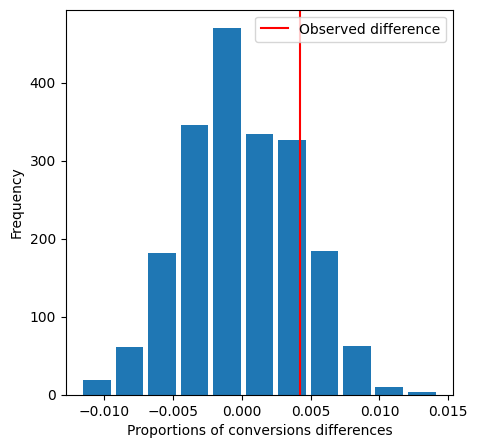

In [409]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

permutation_results = stats.permutation_test(
    (df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'control']['SALE'], df_grouped_users[df_grouped_users['VARIANT_NAME'] == 'variant']['SALE']),
    statistic,
    vectorized=True,
    n_resamples=2000,    
    alternative='greater'
    )

print(f'p-value: {permutation_results.pvalue:.4f}')


fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(permutation_results.null_distribution, bins=11, rwidth=0.85)
ax.axvline(x = observed_difference, color='red', label='Observed difference')
ax.set_xlabel('Proportions of conversions differences')
ax.set_ylabel('Frequency')

ax.legend();
plt.show()

In [410]:
if permutation_results.pvalue >= 0.05:
    results_hypothesis = "Fail to reject the Null Hypothesis"
    results_hypothesis_details = "Seems like there is no difference between Control and Variant groups on proportion of conversions"
else:
    results_hypothesis = "Reject the Null Hypothesis"
    results_hypothesis_details = "Seems like Variant group generates less proportion of conversions"

df_results_proportion_diff_permutation = pd.DataFrame({
    'test_for': "Difference in proportion of conversions",
    'test_type': "Permutation Test",
    'H0': "No difference on proportions of conversions",
    'H1': "Proportions of conversions on Variant group is lower",
    'pvalue': [permutation_results.pvalue],
    'results': results_hypothesis,
    'results_details': results_hypothesis_details
})

df_results = pd.concat([df_results, df_results_proportion_diff_permutation])

df_results_proportion_diff_permutation

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Difference in proportion of conversions,Permutation Test,No difference on proportions of conversions,Proportions of conversions on Variant group is lower,0.178411,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on proportion of conversions


<a name="Z-TEST"></a>
### Z-test

In a similar manner to the t-test, the z-test assumes that the data follows a normal distribution. And just like before, we can utilize the Central Limit Theorem (CLT) because the sample size is large enough to rely on its assumptions and use this test.

In [411]:
n_sales = df_contingency['SALE'].values
n_rows = np.array(df_contingency.sum(axis=1)['control'], df_contingency.sum(axis=1)['variant'])
ztest_results = proportions_ztest(count=n_sales, nobs=n_rows, alternative='larger')

print(f'p-value: {ztest_results[1]:.4f}')


p-value: 0.1488


In [412]:
if ztest_results[1] >= 0.05:
    results_hypothesis = "Fail to reject the Null Hypothesis"
    results_hypothesis_details = "Seems like there is no difference between Control and Variant groups on proportion of conversions"
else:
    results_hypothesis = "Reject the Null Hypothesis"
    results_hypothesis_details = "Seems like Variant group generates less proportion of conversions"

df_results_proportion_diff_ztest = pd.DataFrame({
    'test_for': "Difference in proportion of conversions",
    'test_type': "Z-Test",
    'H0': "No difference on proportions of conversions",
    'H1': "Proportions of conversions on Variant group is lower",
    'pvalue': [ztest_results[1]],
    'results': results_hypothesis,
    'results_details': results_hypothesis_details
})

df_results = pd.concat([df_results, df_results_proportion_diff_ztest])

df_results_proportion_diff_ztest

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Difference in proportion of conversions,Z-Test,No difference on proportions of conversions,Proportions of conversions on Variant group is lower,0.148771,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on proportion of conversions


<a name="TEST-INDEPENDENCE"></a>
### Test of independence

We already have sufficient information to make conclusions about the hypotheses stated before. However, for the sake of curiosity and to explore additional tests in this Notebook, we will conduct a test of independence between the variables in the two groups.

Null Hypothesis (H0) = The proportions of conversions are independent between the Control and Variant groups (control_proportion - variant_proportion = 0).

Alternative Hypothesis (H1) = The proportions of conversions are not independent between the Control and Variant groups (control_proportion != variant_proportion).

<a name="CHI-SQUARE"></a>
### Chi-Square

In [413]:
df_contingency

,NO_SALE,SALE
VARIANT_NAME,,
control,2337,52
variant,2351,42


In [414]:
chi2_results = stats.chi2_contingency(df_contingency)
print(f'p-value: {chi2_results.pvalue:.4f}')

p-value: 0.3443


In [415]:
if chi2_results.pvalue >= 0.05:
    results_hypothesis = "Fail to reject the Null Hypothesis"
    results_hypothesis_details = "Seems like the proportions of conversions are independent between the Control and Variant groups"
else:
    results_hypothesis = "Reject the Null Hypothesis"
    results_hypothesis_details = "Seems like the proportions of conversions are not independent between the Control and Variant groups"

df_results_proportion_diff_chi2 = pd.DataFrame({
    'test_for': "Independence of conversions between groups",
    'test_type': "Chi-square Test",
    'H0': "The proportions of conversions are independent between the groups",
    'H1': "The proportions of conversions are not independent between the groups",
    'pvalue': [chi2_results.pvalue],
    'results': results_hypothesis,
    'results_details': results_hypothesis_details
})

df_results = pd.concat([df_results, df_results_proportion_diff_chi2])

df_results_proportion_diff_chi2

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Independence of conversions between groups,Chi-square Test,The proportions of conversions are independent between the groups,The proportions of conversions are not independent between the groups,0.344286,Fail to reject the Null Hypothesis,Seems like the proportions of conversions are independent between the Control and Variant groups


<a name="FISHER-EXACT-TEST"></a>
### Fisher's Exact Test

Because we have very small proportions, it is more appropriate to do a Fisher's Exact test instead of a Chi-Square test.

In [416]:
df_contingency

,NO_SALE,SALE
VARIANT_NAME,,
control,2337,52
variant,2351,42


In [417]:
fisherexact_results = stats.fisher_exact(df_contingency)

print(f'p-value: {fisherexact_results.pvalue:.4f}')

p-value: 0.2997


In [418]:
if fisherexact_results.pvalue >= 0.05:
    results_hypothesis = "Fail to reject the Null Hypothesis"
    results_hypothesis_details = "Seems like the proportions of conversions are independent between the Control and Variant groups"
else:
    results_hypothesis = "Reject the Null Hypothesis"
    results_hypothesis_details = "Seems like the proportions of conversions are not independent between the Control and Variant groups"

df_results_proportion_diff_fisherexact = pd.DataFrame({
    'test_for': "Independence of conversions between groups",
    'test_type': "Fisher's exact Test",
    'H0': "The proportions of conversions are independent between groups",
    'H1': "The proportions of conversions are not independent between groups",
    'pvalue': [fisherexact_results.pvalue],
    'results': results_hypothesis,
    'results_details': results_hypothesis_details
})

df_results = pd.concat([df_results, df_results_proportion_diff_fisherexact])

df_results_proportion_diff_fisherexact

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Independence of conversions between groups,Fisher's exact Test,The proportions of conversions are independent between groups,The proportions of conversions are not independent between groups,0.299733,Fail to reject the Null Hypothesis,Seems like the proportions of conversions are independent between the Control and Variant groups


<a name="CONCLUSIONS"></a>
## CONCLUSIONS

We performed different test to reject or fail to reject the null hypothesis on different cases.

In [419]:
df_results.reset_index(drop=True)

,test_for,test_type,H0,H1,pvalue,results,results_details
0,Difference in Revenue means,Permutation Test,No difference on Revenue means,Mean Revenue on Variant group is lower,0.155900,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on Revenue means
1,Difference in Revenue means,T-Test,No difference on Revenue means,Mean Revenue on Variant group is lower,0.151482,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on Revenue means
2,Difference in Revenue means,Mann-Whitney U rank Test,No difference on Revenue means,Mean Revenue on Variant group is lower,0.145674,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on Revenue means
3,Difference in proportion of conversions,Permutation Test,No difference on proportions of conversions,Proportions of conversions on Variant group is lower,0.178411,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on proportion of conversions
4,Difference in proportion of conversions,Z-Test,No difference on proportions of conversions,Proportions of conversions on Variant group is lower,0.148771,Fail to reject the Null Hypothesis,Seems like there is no difference between Control and Variant groups on proportion of conversions
5,Independence of conversions between groups,Chi-square Test,The proportions of conversions are independent between the groups,The proportions of conversions are not independent between the groups,0.344286,Fail to reject the Null Hypothesis,Seems like the proportions of conversions are independent between the Control and Variant groups
6,Independence of conversions between groups,Fisher's exact Test,The proportions of conversions are independent between groups,The proportions of conversions are not independent between groups,0.299733,Fail to reject the Null Hypothesis,Seems like the proportions of conversions are independent between the Control and Variant groups


Overall, we can conclude that:
- There is no significant evidence to suggest that Variant group generates less revenue on average than Control group.
- There is no significant evidence to suggest that the proportion of convertions on Variant group is lower than Control group.
- There is no significant evidence to suggest that the proportions of conversions are dependent between the Control and Variant groups.
- Although the data does not strictly met the underlying assumptions required for some of the tests, they all produced similar p-values.
